![Cradlepoint](logo.svg)

---

# **PART 3** - Configuration

#### This section will cover:  

### PUT and PATCH Methods

### Configuration Structure  

### Group Configuration

### Device Configuration
- #### configuration_managers/

---
## Setup

Each notebook in these labs runs a separate kernel and memory space, so you have to start over and setup your python environment.  This is good practice, but if you want a shortcut you can copy the code below and put your keys in it:

---

```python
import requests
import json

headers = {
    'X-ECM-API-ID': 'YOUR',
    'X-ECM-API-KEY': 'KEYS',
    'X-CP-API-ID': 'GO',
    'X-CP-API-KEY': 'HERE',
    'Content-Type': 'application/json'
}

base_url = 'https://www.cradlepointecm.com/api/v2'
```

---

#### Try it out!
_Setup your python environment_

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  

## PUT and PATCH Methods

When you want to send data to the NCM API you will use the requests library's **_.put()_** or **_.patch()_** method.  

When you make a PUT or PATCH request you must include your JSON structured data in the request body.  

A **PUT** request will **_replace_** existing values with what you send in your request body.  

Examples for making a PUT request:
- Change the name, description, or asset_id of a router
- Change the name or target_firmware of a group
- Replace the configuration of a router or group

A **PATCH** request will **_merge_** existing values with what you send in your request body.  Patch is smart and works the way you would expect; it adds new fields, and overwrites existing fields, but does not delete any fields.

#### PATCH is only supported on "configuration" fields.

---

## Configuration Structure

Cradlepoint router configurations are a diff (difference) from the factory default configuration in JSON format.

The configuration structure is a **list** with two items: 
- a dictionary of adds/changes from default
- a list of removals from default

Below is an example containing both.  

This configuration sets the system_id (router name) in the add/change **dictionary**, and removes a LAN ("Guest LAN") in the removals **list**.

```json
[{
		"system": {
			"system_id": "NewName"
		}
	},
	[
		[
			"lan",
			"00000001-0d93-319d-8220-4a1fb0372b51"
		]
	]
]
```

---

## Group Configuration

Group configurations are simply stored in the "configuration" value of a group.  
  
The below example shows a group that has the "configuration" from the previous example:

```json
{
	"account": "https://www.cradlepointecm.com/api/v2/accounts/495/",
	"configuration": [
        {
            "system": {
                "system_id": "NewName"
            }
        },
        [
            [
                "lan",
                "00000001-0d93-319d-8220-4a1fb0372b51"
            ]
        ]
    ],
	"device_type": "router",
	"id": "202007",
	"name": "My Router Group",
	"product": "https://www.cradlepointecm.com/api/v2/products/41/",
	"resource_url": "https://www.cradlepointecm.com/api/v2/groups/202007/",
	"target_firmware": "https://www.cradlepointecm.com/api/v2/firmwares/6387/"
}
```

---

## Device Configuration

#### NCM manages many layers of configurations in addition to the group config.  

#### It uses the aptly named **configuration_managers/** endpoint to do so.

The following configuration values can be found on the **configuration_managers/** endpoint:
- **device** config - The configuration of the individual router in NCM (AKA "indie" config)
- **target** config - The configuration that NCM intends the local router to have
- **actual** config - The configuration of the _actual_ local router
- **pending** config - The changes to be patched to the local router to _sync_ it with **target** config

The **configuration_managers/** endpoint also has the following noteable fields:  
- **synced** - Boolean - True if configuration is synced between router and NCM (**target** == **actual**)
- **suspended** - Boolean - True if NCM or the router has rejected a configuration.  Prevents further config synchronization until set to False.

#### Any time a group or device configuration in NCM is updated it triggers the following configuration synchronization process:  
  
- The **device** configuration is _"patched"_ into the **group** configuration (if any) to determine the **target** configuration.
- A _"diff"_ is performed between the **target** and **actual** configuration (what is on the router) to determine the **pending** configuration.
- The **pending** config is pushed to the router via stream protocol and the **synced** value is set to False
- The router starts a 900 second (15min) rollback timer and disconnects from NCM
- The router patches the received **pending** config into it's local configuration (running/saved)
- The router reconnects to NCM and syncs it's **actual** config, setting **sycned** to True
- The router stops the rollback timer  
  
> #### If the rollback timer expires before the router is unable to reconnect to NCM, it is determined that the configuration caused a connectivity issue and the changes are rolled back.  Then the router reconnects to NCM (using prior working config) and sets the **suspended** flag to True.  
  
> #### To resume configuration synchronization, fix the configuration issue (see "Last sync error" in NCM UI for help), then set **suspended** to False (this is the same as clicking "Resume Updates" in the NCM UI).

#### When local changes are made to the router configuration, the changes are pushed up and synced with the **actual** and **configuration** fields in NCM.

---

### Get your router's configuration:

#### To get your router's configuration, you need to make a **GET** request to the **configuration_managers/** endpoint and filter on a unique value for your router, such as router ID, MAC Address, or Serial Number.

Filter on router ID:
https://www.cradlepointecm.com/api/v2/configuration_managers/?router=12345

Filter on router MAC:
https://www.cradlepointecm.com/api/v2/configuration_managers/?router.mac=003044123456

Filter on router Serial Number:
https://www.cradlepointecm.com/api/v2/configuration_managers/?router.serial_number=WA2308TA001234

> #### PROTIP: When you make a GET request to a _pluralized_ endpoint like routers/, net_devices/, or configuration_managers/ and filter the output, the response "data" will be a list/array of matches, even if there is only one.  If there is only one item you still need to reference the first item in the list [0] :

```python
response.json().get('data')[0]
```

> If Python throws an exception "List indices must be integers" or similar, check that you have reference the list item.  
  
You may get a large amount of returned "data" as there are many expanded configuration layers.  You can see the **configuration** field, which is the router's device configuration ("indie").  
  
#### Also in the returned "data" is the **resource_url**.  This is the direct URL to the routers configuration_manager resource.  Assign this value to a new variable called _config_man_url_.  Use this URL to when making a **PUT** or **PATCH** request to change your routers configuration.
  
---

Python Example:

```python
response = requests.get(f'{base_url}/configuration_managers/?router=3382992', headers=headers)
config_man = response.json().get('data')[0]
config_man_url = config_man.get('resource_url')
print(json.dumps(config_man, indent=4))
```

---

Response Example (configs removed for readability):
```json
[
    {
        "account": "https://www.cradlepointecm.com/api/v2/accounts/123/",
        "actual": [...],
        "configuration": [...],
        "resource_url": "https://www.cradlepointecm.com/api/v2/configuration_managers/3456789/",
        "router": "https://www.cradlepointecm.com/api/v2/routers/2345678/",
        "suspended": false,
        "synched": true,
        "target": [...],
        "version_number": 123
    }
]
```
---

#### Try it out!
- Make a GET request to the configuration_managers/ endpoint and filter for your router
- Put the contents of the "data" section of the response in a variable like _config_man_
- Put the value of the **resource_url** in a variable like _config_man_url_
- Print the new variable (_config_man_) with indentation for readability

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  

### Creating JSON Configurations

#### Don't create JSON configurations from scratch!

Creating a router configuration in JSON format is difficult.  Wether or not you are starting a new config or making a small change to an existing config, I recommend using this shortcut:  
  
**Copy JSON from the NCM Config Editor!**  
Use the NCM Configuration Editor to make your config changes, then press "View Pending Changes" and copy the JSON.  You do not have to submit the changes - just copy the JSON and discard changes.  Then use that JSON in your script and modify it as necessary.  This will ensure that you have the removals sections and everything is formatted correctly.  
<img src=attachment:e5c51a10-1cba-45b1-8e6c-a56bc250866f.png height=600 width=800>
  

#### Create a new dictionary in python called _my_json_ with a "configuration" key and paste your config as the value:  

```python
my_json = {
	"configuration": [{
			"system": {
				"system_id": "ROUTER-NAME"
			}
		},
		[]
	]
}
```

---

> Another great tool for validating JSON formatting: www.jsonlint.com

---

#### Try it out!
- Use the NCM Config Editor to change the name of a router and copy the pending JSON config
- Paste the config into python, assigning it to a new variable called _new_config_

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  
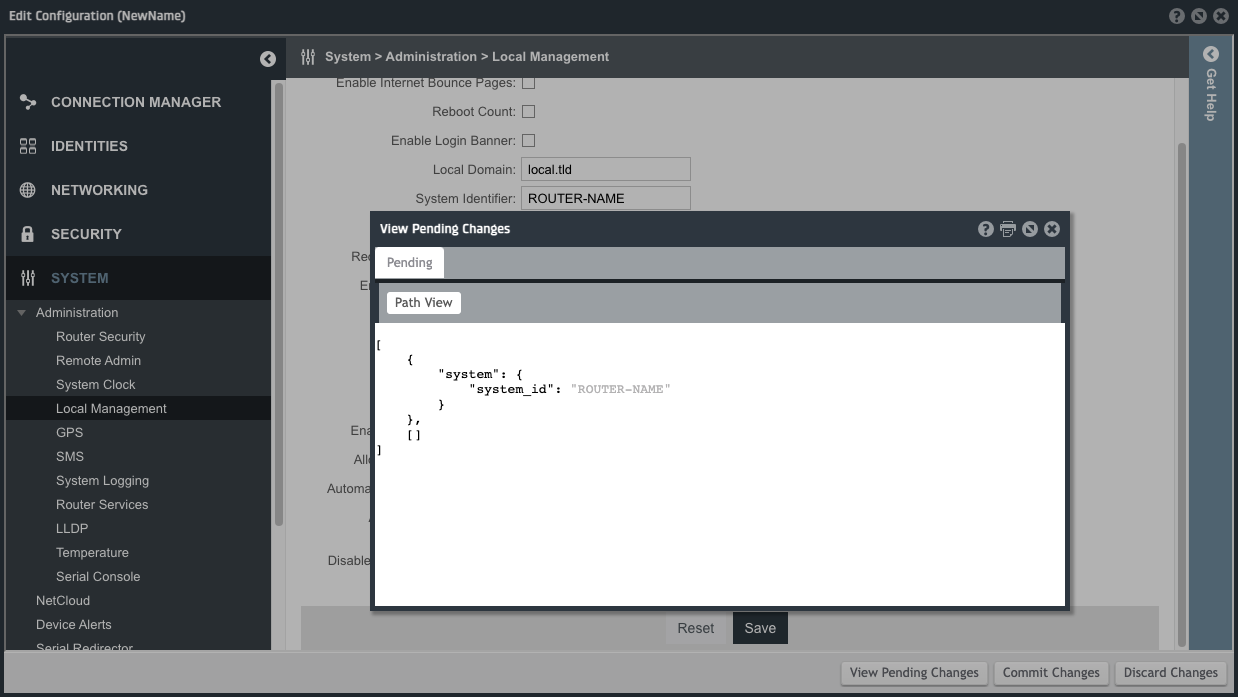

### Making a PATCH Request

Use the requests module's **patch** method to patch your changes to the _config_man_url_.  You can pass your config (_my_json_) as the **json** keyword argument.  

Print the response.  You are expecting a 202, which means "Accepted".

```python
response = requests.patch(config_man_url, headers=headers, json=my_json)
print(response)
```


<Response [202]>



### Making a PUT Request

Use the requests module's **put** method to completely replace your configuration with the body you send.

```python
response = requests.put(config_man_url, headers=headers, json=my_json)
```

We will skip this example as we don't want to wipe our router config.  It is most common to **patch** changes to your configurations.

---

## Congratulations on Completing Part 3 of the NCM API Labs!
Continue to part 4 in the file browser on the left.